In [ ]:
install.packages("caTools")
install.packages("caret")
install.packages("e1071")
install.packages("ROCR")
install.packages("pROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gplots’




In [85]:
library(caTools)
library(caret)
library(e1071)
library(ROCR)
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [30]:
donnees <- read.table("maj_data.data", header = TRUE, sep = ",")

In [31]:
head(donnees)

,X,X2,X30,X2.1,X1,X2.2,X2.3,X2.4,X2.5,X1.1,⋯,X2.7,X2.8,X2.9,X2.10,X1.00,X85,X18,X4.0,X.,X1.2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,1,2,50,1,1,2,1,2,2,1,⋯,2,2,2,2,0.9,135.000,42,3.5,61.85227,1
2,2,2,78,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,96.000,32,4.0,61.85227,1
3,4,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,200,4.0,61.85227,1
4,5,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,0.9,95.000,28,4.0,75.00000,1
5,8,2,39,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,105.488,48,4.4,61.85227,1
6,9,2,30,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,120,3.9,61.85227,1


In [32]:
print(colnames(donnees))

 [1] "X"     "X2"    "X30"   "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5" 
[10] "X1.1"  "X2.6"  "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.00" "X85"   "X18"  
[19] "X4.0"  "X."    "X1.2" 


In [33]:
#On trie les variables potentielles dépendantes et potentielles indépendantes
variables_dependantes_potentielles <- character(0)
variables_independantes_potentielles <- character(0)

for (col in names(donnees)) {
  unique_vals <- unique(donnees[[col]])

  #On vérifie si la variable a seulement deux niveaux (binaire)
  if (length(unique_vals) == 2) {
    variables_dependantes_potentielles <- c(variables_dependantes_potentielles, col)
  }
  else{
    variables_independantes_potentielles <- c(variables_independantes_potentielles, col)
  }


}

#On affiche les variables potentielles dépendantes
print(variables_dependantes_potentielles)
cat('\n\n')
#On affiche les variables potentielles indépendantes
print(variables_independantes_potentielles)

 [1] "X2"    "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5"  "X1.1"  "X2.6" 
[10] "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.2" 


[1] "X"     "X30"   "X1.00" "X85"   "X18"   "X4.0"  "X."   


In [34]:
param_interet <- "X1.2"

In [35]:
param_independant_1 <- "X30"
param_independant_2 <- "X18"

param_independants <- c(param_independant_1, param_independant_2)
print(param_independants)

[1] "X30" "X18"


In [36]:
head(donnees[param_interet])

,X1.2
,<int>
1,1
2,1
3,1
4,1
5,1
6,1


In [37]:
head(donnees[param_independant_1])

,X30
,<int>
1,50
2,78
3,34
4,34
5,39
6,30


In [38]:
head(donnees[param_independant_2])

,X18
,<int>
1,42
2,32
3,200
4,28
5,48
6,120


In [71]:
#Fonction permettant l'application du modèle svm lineaire
# parametres : le dataset, le paramètre d'interet

fonctionRegressionLogistique<- function(donnees, interet, var_independante_1, var_independante_2) {
  set.seed(123)

  #Faire de la variable dependante un facteur (categorique)
  #donnees[[interet]] pour donnees$interet
  donnees[[interet]] <- as.factor(donnees[[interet]])

  data_interet <- donnees[, c(interet, var_independante_1, var_independante_2)]

  #echantillonnage trainset et testset
  indices <- createDataPartition(data_interet[[interet]], p = 0.7, list = FALSE)
  data_train <- data_interet[indices, ]
  data_test <- data_interet[-indices, ]


  #construction du modele

  #idee
  my_formula <- reformulate(c(var_independante_1, var_independante_2), response = interet)

  modele <- glm(formula = my_formula, data = data_train, family = "binomial")


  print(modele)
  #summary(modele)

  cat("\n\n")

  #prediction
  pred <- predict(modele, data_test)

  #Définir un seuil
  seuil <- 0.5

  #Convertir les probabilités en classes en fonction du seuil
  classes_predites <- ifelse(pred >= seuil, 2, 1)

  #Matrice de confusion
  mat_conf <- table(observed = data_test[[interet]], predicted = classes_predites)
  cat("Matrice de confusion sur de nouvelles données:\n\n")
  print(mat_conf)

  return(list(modele, data_train, data_test, mat_conf))
}

In [72]:
model_log <- fonctionRegressionLogistique(donnees, param_interet, param_independant_1, param_independant_2)

donnees_log <- model_log[[1]]
donnees_train <- model_log[[2]]
donnees_test <- model_log[[3]]
mat_c <- model_log[[4]]


Call:  glm(formula = my_formula, family = "binomial", data = data_train)

Coefficients:
(Intercept)          X30          X18  
  -1.200607     0.015175     0.004664  

Degrees of Freedom: 89 Total (i.e. Null);  87 Residual
Null Deviance:	    123.7 
Residual Deviance: 120.7 	AIC: 126.7


[1] 38
Matrice de confusion sur de nouvelles données:

        predicted
observed  1  2
       1 20  1
       2 17  0


In [73]:
getPrecision_Recall_FScore <- function(mat_conf) {
  #On extrait les valeurs de la matrice de confusion
  tp <- mat_conf[2, 2]  # True Positives
  fp <- mat_conf[1, 2]  # False Positives
  fn <- mat_conf[2, 1]  # False Negatives

  print(tp)
  print(fp)
  print(fn)

  # Calculer la précision, le rappel et le F-score
  precision <- tp / (tp + fp)
  recall <- tp / (tp + fn)
  fscore <- 2 * (precision * recall) / (precision + recall)


  # Afficher les résultats
  cat("Precision:", precision, "\n")
  cat("Recall:", recall, "\n")
  cat("Fscore:", fscore, "\n")

  return(c(precision,recall,fscore))
}

In [74]:
res <- getPrecision_Recall_FScore(mat_c)

[1] 0
[1] 1
[1] 17
Precision: 0 
Recall: 0 
Fscore: NaN 


In [103]:
afficheROCRegressionLogistique <- function(modele,donnees_test,interet){

  #Prédiction des probabilités avec le modèle svm sur le jeu de données de test
  pred_prob <- predict(modele, newdata = donnees_test, type = "response")

  #Obtention des vraies étiquettes (valeurs de la variable cible) à partir du jeu de données de test
  true_labels <- donnees_test[[interet]]

  roc_obj <- roc(true_labels, pred_prob)

  #AUC
  auc <- auc(roc_obj)
  cat("AUC = ", auc)

  #ROC curve
  plot(roc_obj,main="ROC Curve pour la Régression Logistique",col=2,lwd=2)
  abline(a=0,b=1,lwd=2,lty=2,col="gray")
}

Setting levels: control = 1, case = 2

Setting direction: controls < cases



AUC =  0.6890756

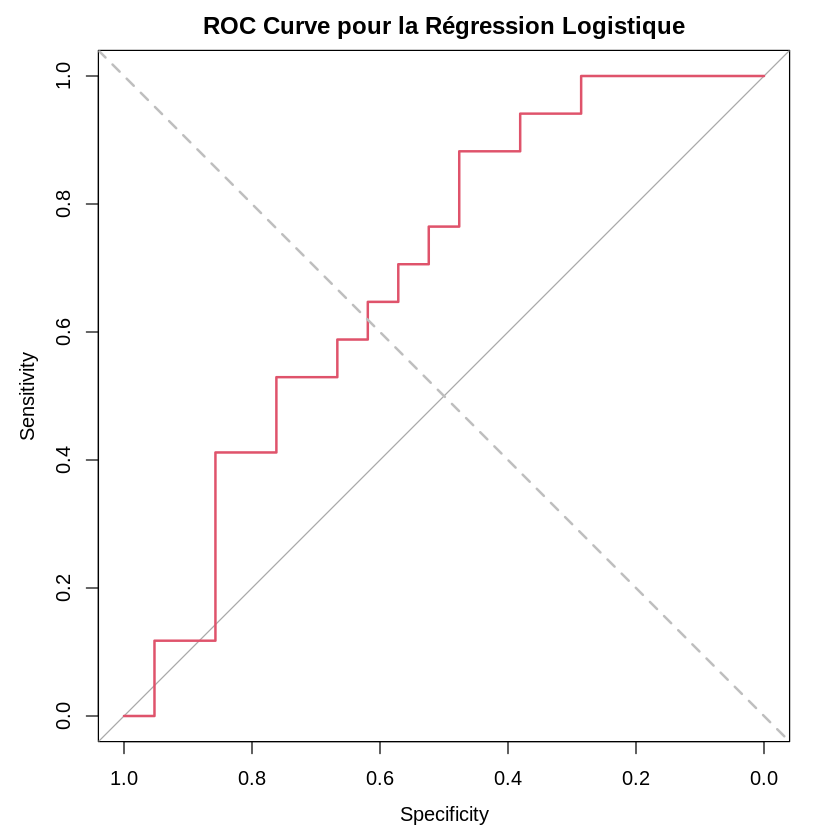

In [104]:
afficheROCRegressionLogistique(donnees_log,donnees_test,param_interet)